Scanning for data in: /Users/ktgiahieu/Documents/review-assistant/data/metareviews
--- Loaded Data Structure ---
-----------------------------

Processing detailed model-venue data...

--- Final Detailed Results (Model, Venue) ---
-------------------------------------------



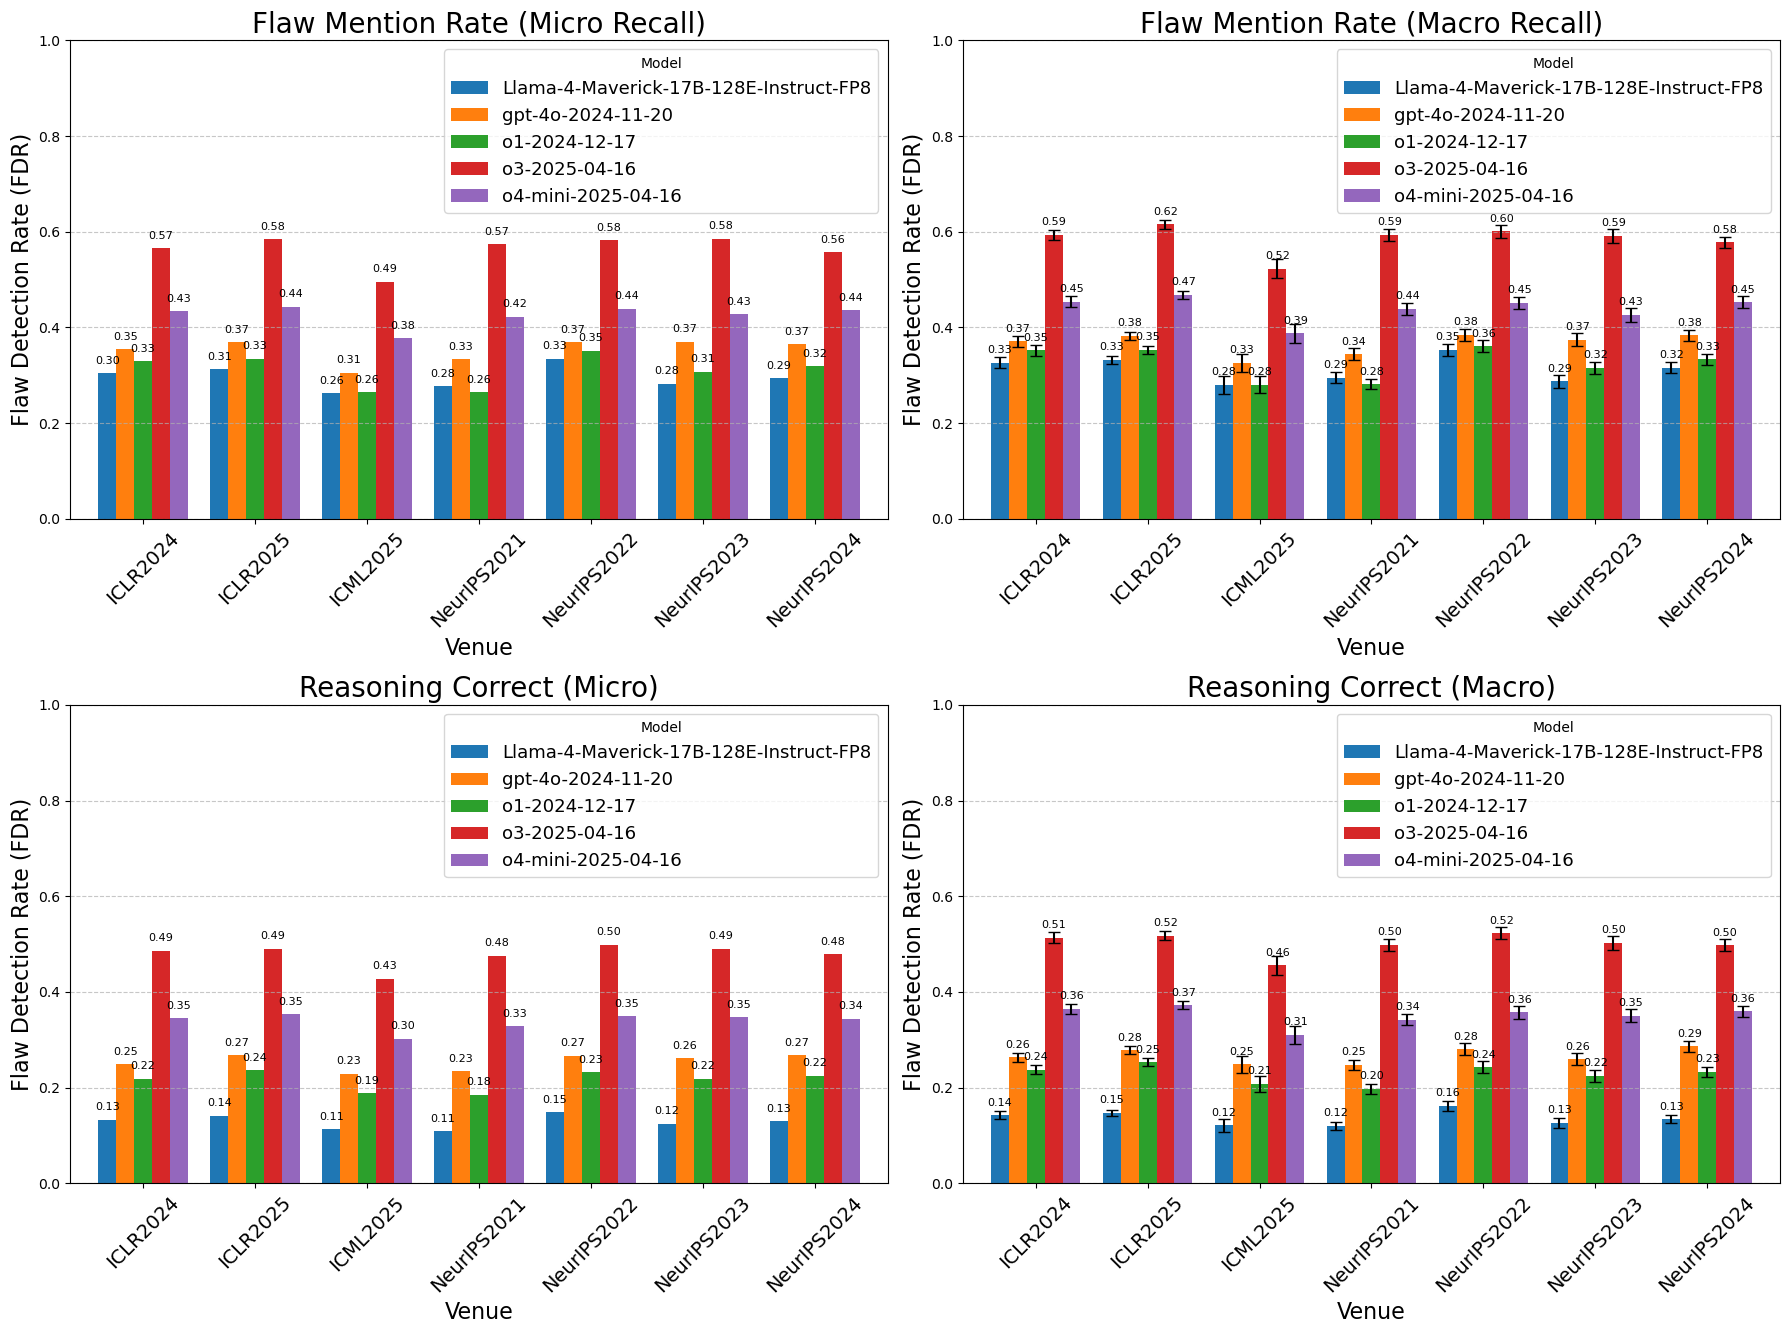

In [9]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint

def load_data_from_file(filepath):
    """Loads JSON data from a single file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error reading or parsing {filepath}: {e}")
        return None

def load_all_data_structured(base_path):
    """
    Scans the directory structure to find and load all JSON files,
    categorizing them by the generating LLM (o3, o4-mini, etc.), venue, 
    and acceptance status.
    """
    structured_data = []
    base_path_abs = os.path.abspath(base_path)
    print(f"Scanning for data in: {base_path_abs}")
    
    if not os.path.exists(base_path):
        print(f"Warning: Base directory not found at {base_path_abs}")
        return []

    for model_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_name)
        if os.path.isdir(model_path):
            for root, dirs, files in os.walk(model_path):
                for file in files:
                    if file.endswith(".json"):
                        filepath = os.path.join(root, file)
                        norm_root = os.path.normpath(root)
                        path_parts = norm_root.split(os.sep)
                        
                        try:
                            model_index = path_parts.index(model_name)
                            if len(path_parts) > model_index + 2:
                                venue = path_parts[model_index + 1].replace('_latest_flawed_papers_v1', '')
                                status = path_parts[model_index + 2]
                            else:
                                venue, status = 'unknown', 'unknown'
                        except ValueError:
                            venue, status = 'unknown', 'unknown'
                        if venue == 'ICML2024':
                            continue
                        data = load_data_from_file(filepath)
                        if data:
                            record = {
                                'model': model_name,
                                'venue': venue,
                                'status': status,
                                'data': data
                            }
                            structured_data.append(record)

    if not structured_data:
        print("Warning: No data files were found. Check the BASE_DIRECTORY path and structure.")
    return structured_data

def calculate_metrics(model_data):
    """
    Calculates micro and macro averaged ratios for flaw detection
    and reasoning correctness, including standard error for macro averages.
    """
    if not model_data:
        return {
            'micro_mention_ratio': 0, 'macro_mention_ratio': 0, 'macro_mention_sem': 0,
            'micro_reasoning_ratio': 0, 'macro_reasoning_ratio': 0, 'macro_reasoning_sem': 0
        }

    total_flaws, total_mentions, total_correct_reasoning = 0, 0, 0
    paper_mention_ratios, paper_reasoning_ratios = [], []

    for paper_id, flaws in model_data.items():
        if not isinstance(flaws, list) or not flaws:
            continue

        num_flaws_in_paper = len(flaws)
        mentions_in_paper = sum(1 for f in flaws if isinstance(f, dict) and f.get('is_flaw_mentioned'))
        correct_reasoning_in_paper = sum(1 for f in flaws if isinstance(f, dict) and f.get('is_reasoning_correct'))

        total_flaws += num_flaws_in_paper
        total_mentions += mentions_in_paper
        total_correct_reasoning += correct_reasoning_in_paper

        if num_flaws_in_paper > 0:
            paper_mention_ratios.append(mentions_in_paper / num_flaws_in_paper)
            paper_reasoning_ratios.append(correct_reasoning_in_paper / num_flaws_in_paper)

    # --- Micro Averages ---
    micro_mention_ratio = total_mentions / total_flaws if total_flaws > 0 else 0
    micro_reasoning_ratio = total_correct_reasoning / total_flaws if total_flaws > 0 else 0
    
    # --- Macro Averages and Standard Error of the Mean (SEM) ---
    macro_mention_ratio = np.mean(paper_mention_ratios) if paper_mention_ratios else 0
    macro_reasoning_ratio = np.mean(paper_reasoning_ratios) if paper_reasoning_ratios else 0
    
    n_papers = len(paper_mention_ratios)
    if n_papers > 1:
        mention_sem = np.std(paper_mention_ratios, ddof=1) / np.sqrt(n_papers)
        reasoning_sem = np.std(paper_reasoning_ratios, ddof=1) / np.sqrt(n_papers)
    else:
        mention_sem, reasoning_sem = 0, 0

    return {
        'micro_mention_ratio': micro_mention_ratio,
        'macro_mention_ratio': macro_mention_ratio,
        'macro_mention_sem': mention_sem,
        'micro_reasoning_ratio': micro_reasoning_ratio,
        'macro_reasoning_ratio': macro_reasoning_ratio,
        'macro_reasoning_sem': reasoning_sem
    }

def plot_detailed_results(results_df):
    """
    Plots performance metrics with error bars for macro averages,
    creating a separate plot for each metric, grouped by venue.
    """
    if results_df.empty:
        print("No detailed results to plot.")
        return

    # Define which metrics are which type for plotting logic
    metric_map = {
        'Flaw Mention Rate (Micro Recall)': None, # No error bar
        'Flaw Mention Rate (Macro Recall)': 'Flaw Mention Rate (Macro Recall) SEM',
        'Reasoning Correct (Micro)': None, # No error bar
        'Reasoning Correct (Macro)': 'Reasoning Correct (Macro) SEM'
    }

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
    # fig.suptitle('LLM Performance by Venue', fontsize=20)
    ax_flat = axes.flatten()

    for i, (metric, err_metric_name) in enumerate(metric_map.items()):
        ax = ax_flat[i]
        
        # Unstack to pivot models into columns for grouped bar plot
        plot_data = results_df[metric].unstack(level='model')
        error_data = None
        
        if err_metric_name:
            # Also unstack the error data to align it with the plot data
            error_data = results_df[err_metric_name].unstack(level='model')

        plot_data.plot(kind='bar', ax=ax, width=0.8, yerr=error_data, capsize=4)

        ax.set_title(metric, fontsize=20)
        ax.set_ylabel('Flaw Detection Rate (FDR)', fontsize=16)
        ax.set_xlabel('Venue', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.set_ylim(0, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(title='Model', fontsize=13)

        # Add value labels (on the bars, not on the error bars)
        for p in ax.patches:
             # Only add labels to bars, not error bar caps
            if p.get_height() > 0:
                ax.annotate(f"{p.get_height():.2f}",
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 9),
                            textcoords='offset points', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    BASE_DIRECTORY = '../data/metareviews'

    all_structured_data = load_all_data_structured(BASE_DIRECTORY)
    
    print("--- Loaded Data Structure ---")
    print("-----------------------------\n")

    # Aggregate data per model and venue
    detailed_aggregated_data = {}
    for record in all_structured_data:
        key = (record['model'], record['venue'])
        if key not in detailed_aggregated_data:
            detailed_aggregated_data[key] = {}
        detailed_aggregated_data[key].update(record['data'])

    # Calculate metrics for each (model, venue) combination
    detailed_results = {}
    print("Processing detailed model-venue data...")
    for (model_name, venue), combined_data in sorted(detailed_aggregated_data.items()):
        # print(f" - Analyzing model: {model_name} for venue: {venue}")
        metrics = calculate_metrics(combined_data)
        detailed_results[(model_name, venue)] = metrics

    # Create a DataFrame with a MultiIndex
    detailed_results_df = pd.DataFrame.from_dict(detailed_results, orient='index')
    if not detailed_results_df.empty:
        detailed_results_df.index = pd.MultiIndex.from_tuples(
            detailed_results_df.index, names=['model', 'venue']
        )
        detailed_results_df.rename(columns={
            'micro_mention_ratio': 'Flaw Mention Rate (Micro Recall)',
            'macro_mention_ratio': 'Flaw Mention Rate (Macro Recall)',
            'macro_mention_sem': 'Flaw Mention Rate (Macro Recall) SEM',
            'micro_reasoning_ratio': 'Reasoning Correct (Micro)',
            'macro_reasoning_ratio': 'Reasoning Correct (Macro)',
            'macro_reasoning_sem': 'Reasoning Correct (Macro) SEM'
        }, inplace=True)

    print("\n--- Final Detailed Results (Model, Venue) ---")
    # print(detailed_results_df)
    print("-------------------------------------------\n")

    # Plot the detailed results
    plot_detailed_results(detailed_results_df)



/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_73890/1367639033.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Count', data=category_df, palette='plasma')


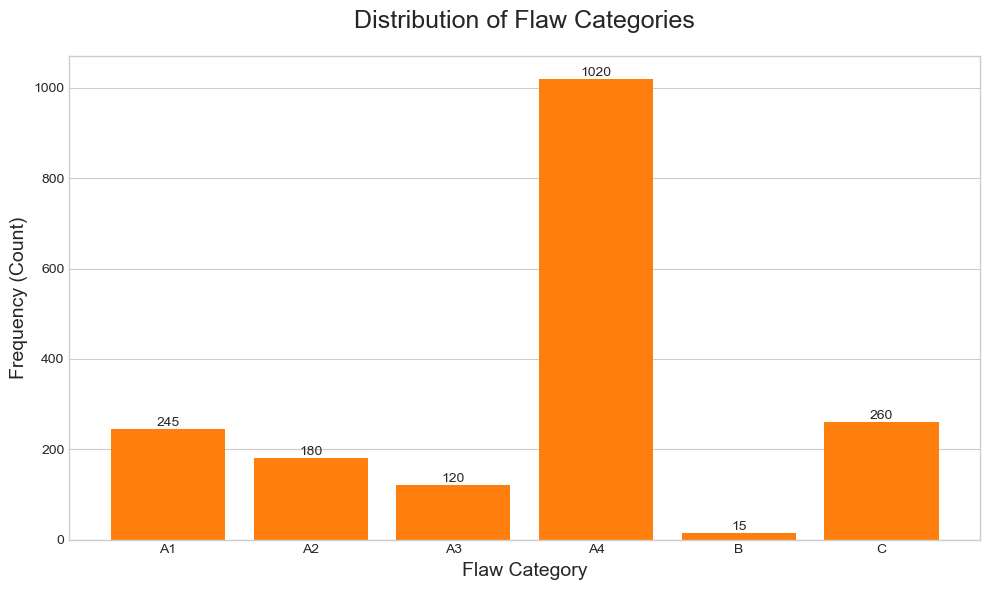

In [15]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import os

def plot_category_distribution(file_path):
    """
    Loads flaw data from a JSON file, counts the occurrences of each
    category (e.g., A1, A2, C), and generates a bar plot to visualize
    their distribution.

    Args:
        file_path (str): The path to the JSON file containing the flaw data.
    """
    # 1. Load the data from the specified JSON file.
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure the JSON file exists in the same directory as the script.")
        return
    except json.JSONDecodeError:
        print(f"Error: The file '{file_path}' is not a valid JSON file.")
        return

    # 2. Extract all category codes into a single list.
    # The category codes are the values in the inner dictionaries.
    all_categories = []
    for item in data.values():
        all_categories.extend(item.values())

    # 3. Count the occurrences of each unique category.
    category_counts = Counter(all_categories)

    # 4. If there's no data, print a message and exit.
    if not category_counts:
        print("No category data to plot.")
        return

    # 5. Convert the counter to a pandas DataFrame for plotting.
    # The DataFrame will have 'Category' and 'Count' columns.
    # We sort by category name to ensure a consistent order (A1, A2, A3...).
    category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count'])
    category_df = category_df.sort_values(by='Category')
    category_df.Count = category_df.Count*5

    # 6. Create the plot.
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6)) # Use a standard size for a vertical bar chart.
    
    # Use seaborn to create a vertical bar plot.
    ax = sns.barplot(x='Category', y='Count', data=category_df, palette='plasma')

    # 7. Customize the plot for clarity.
    ax.set_title('Distribution of Flaw Categories', fontsize=18, pad=20)
    ax.set_xlabel('Flaw Category', fontsize=14)
    ax.set_ylabel('Frequency (Count)', fontsize=14)
    
    # Add the count number on top of each bar for precise reading.
    ax.bar_label(ax.bar(category_df.Category, category_df.Count))

    # Ensure layout is tight and all labels are visible.
    plt.tight_layout()

    # 8. Display the plot.
    plt.show()

# --- Main execution ---
if __name__ == "__main__":
    # Define the name of the JSON file to read from.
    # IMPORTANT: You must create a file named 'flaws.json' in the same
    # directory and paste your JSON data into it.
    json_file_name = 'test_cate.json'
    
    # The original data to be written to the file for demonstration.
    # In a real scenario, this file would already exist.


    # Call the function with the file path.
    plot_category_distribution(json_file_name)

